#### Assignment 1 - Alex Ceccotti - 790497

In [1]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
def merge(img1, img2, n_match=0, col=(255,255,0), direction="horizontal", set_dim=False, set_h=0, set_w=0):
    sift = cv.xfeatures2d.SIFT_create()
    (kps1, features1) = sift.detectAndCompute(img1, None)
    img1_kps = cv.drawKeypoints(img1, kps1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    (kps2, features2) = sift.detectAndCompute(img2, None)
    img2_kps = cv.drawKeypoints(img2, kps2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    bf = cv.BFMatcher(crossCheck=True)
    matches = bf.match(features1, features2)
    matches = sorted(matches, key=lambda x:x.distance)
    if n_match<1:
        n_match=int(len(matches)*0.3)
    img_match = cv.drawMatches(img1, kps1, img2, kps2, matches[0:n_match], None, matchColor=col)
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    M, mask = cv.findHomography(dst_pts, src_pts, cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    draw_params = dict(matchColor = col,
                   singlePointColor = None,
                   matchesMask = matchesMask,
                   flags = 2)
    img_homog = cv.drawMatches(img1,kps1,img2,kps2,matches,None,**draw_params)
    if set_dim==False:
        if direction=="horizontal":
            set_h = max(img1.shape[0], img2.shape[0])
            set_w = img1.shape[1] + img2.shape[1]
        elif direction=="vertical":
            set_h = img1.shape[0] + img2.shape[0]
            set_w = max(img1.shape[1], img2.shape[1])
        else:
            set_h = img1.shape[0] + img2.shape[0]
            set_w = img1.shape[1] + img2.shape[1]
    img_fin = cv.warpPerspective(img2,M,(set_w,set_h))
    h, w = (img1.shape[0], img1.shape[1])
    img_fin[0:h,0:w] = img1
    return [(img1_kps, img2_kps), img_match, img_homog, img_fin]

Carico le due immagini da unire (in b/n).

In [3]:
gm1 = cv.imread("images/gm1.png",0)
gm2 = cv.imread("images/gm2.png",0)

Utilizzando la funzione "merge" è possibile fare stitching di due immagini con una porzione comune.
La funzione "merge" sfrutta l'algoritmo SIFT per trovare i keypoints e le rispettive features delle due immagini. Vengono poi fatti i matching tra i keypoints e, tramite RANSAC, viene trovata l'omografia che consentirà poi di unire le due immagini di partenza. La funzione "merge" restituisce 4 oggetti: una tupla contenente le due immagini in cui sono evidenziati i keypoints, un'immagine in cui si mostrano un determinato numero di match, un'immagine in cui si mostrano solo i match coerenti con l'omografia e l'immagine finale, ovvero la sovrapposizione corretta delle due immagini di partenza.

In [4]:
(imgs_kps, img_match, img_homog, img_fin) = merge(gm1, gm2)

Plot dei keypoints della prima immagine.

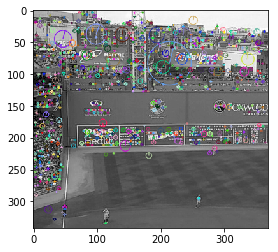

In [5]:
plt.imshow(imgs_kps[0], 'gray'); plt.show()

Plot dei keypoints della seconda immagine.

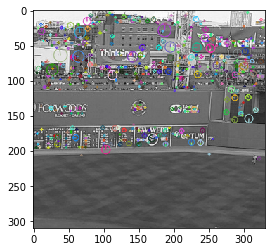

In [6]:
plt.imshow(imgs_kps[1], 'gray'); plt.show()

Plot dei match con distanza tra feature meno elevata (di default la funzione resituisce un numero di match pari al 30% del numero complessivo di match).

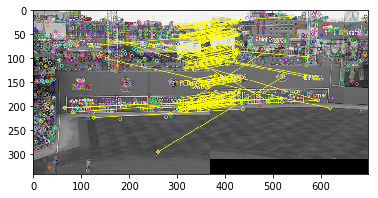

In [7]:
plt.imshow(img_match, 'gray'); plt.show()

La funzione permette di settare il numero di match da visualizzare (ad esempio: 100).

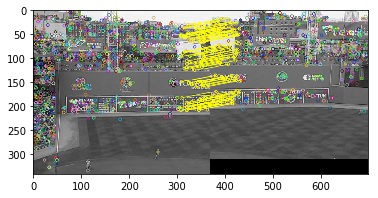

In [8]:
(imgs_kps, img_match, img_homog, img_fin) = merge(gm1, gm2, n_match=100)
plt.imshow(img_match, 'gray'); plt.show()

Plot dei match coerenti con l'omografia.

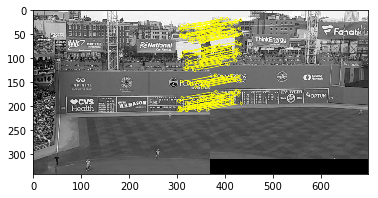

In [9]:
plt.imshow(img_homog, 'gray'); plt.show()

Plot delle due immagini unite.

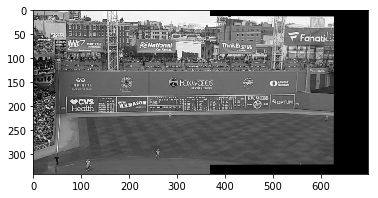

In [10]:
plt.imshow(img_fin, 'gray'); plt.show()

La funzione "merge" permette anche di settare le dimensioni dell'immagine finale, che altrimenti verrebbero calcolate automaticamente all'interno della funzione stessa. Questo consente di rimuovere, ad esempio, il bordo nero che si viene a creare.

In [11]:
(imgs_kps, img_match, img_homog, img_fin) = merge(gm1, gm2, set_dim=True, set_h=342, set_w=630)

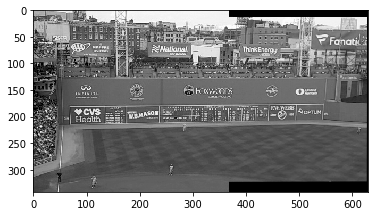

(<matplotlib.image.AxesImage at 0x1b5dff7c1d0>, None)

In [12]:
plt.imshow(img_fin, 'gray'),plt.show()

La funzione è applicabile anche alle immagini a colori.

In [13]:
gm1 = cv.imread("images/gm1.png",1)
gm2 = cv.imread("images/gm2.png",1)

In [14]:
(imgs_kps, img_match, img_homog, img_fin) = merge(gm1, gm2, set_dim=True, set_h=342, set_w=630)

Matplotlib utilizza i 3 canali in ordine diverso rispetto al modo in cui questi vengono utilizzati dalla libreria OpenCV. Per questo motivo, prima di visualizzare l'immagine, vanno riordinati i 3 canali.

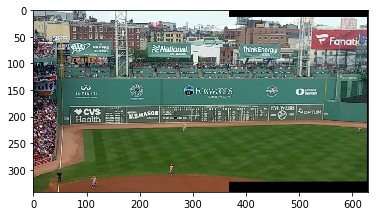

(<matplotlib.image.AxesImage at 0x1b5dffcbc50>, None)

In [15]:
b,g,r = cv.split(img_fin); img_fin = cv.merge([r,g,b])
plt.imshow(img_fin),plt.show()

Di default, i match vengono rappresentati con delle linee gialle. Tuttavia, invertendo i 3 canali per visualizzare opportunamente l'immagine a colori, anche il colore delle linee dei match cambia.

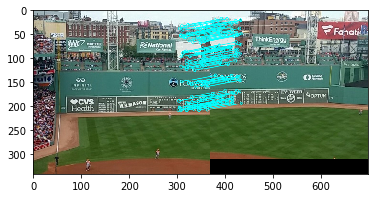

In [16]:
b,g,r = cv.split(img_homog); img_homog = cv.merge([r,g,b])
plt.imshow(img_homog); plt.show()

La funzione "merge" consente di cambiare il colore delle linee dei match.

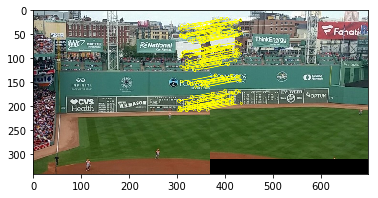

In [17]:
(imgs_kps, img_match, img_homog, img_fin) = merge(gm1, gm2, col=(0,255,255), set_dim=True, set_h=342, set_w=630)
b,g,r = cv.split(img_homog); img_homog = cv.merge([r,g,b])
plt.imshow(img_homog); plt.show()

La funzione permette di settare anche la direzione in cui fare stitching delle due immagini (orizzontale o verticale).

In [18]:
bv1 = cv.imread("images/bv1.png",1)
bv2 = cv.imread("images/bv2.png",1)

Settando il parametro direction="vertical", le dimensioni dell'immagine finale vengono calcolate tenendo conto dell'orientamento dello stiching.

In [19]:
(imgs_kps, img_match, img_homog, img_fin) = merge(bv1, bv2, col=(0,255,255), direction="vertical")

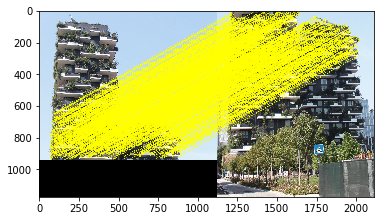

In [20]:
b,g,r = cv.split(img_homog); img_homog = cv.merge([r,g,b])
plt.imshow(img_homog); plt.show()

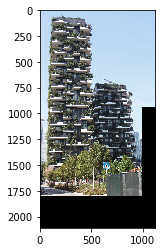

(<matplotlib.image.AxesImage at 0x1b5dfc41a20>, None)

In [21]:
b,g,r = cv.split(img_fin); img_fin = cv.merge([r,g,b])
plt.imshow(img_fin),plt.show()